In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'Harsh@123',
                             database = 'ecommerce')

cur = db.cursor()

# List all unique cities where customers are located

In [2]:
query = """ SELECT DISTINCT customer_city FROM customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [3]:
query = """ SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

# Find the total sales per category

In [4]:
query = """ SELECT UPPER(products.product_category) category, 
ROUND(SUM(payments.payment_value),2) sales
FROM products JOIN order_items 
ON products.product_id = order_items.product_id
JOIN payments 
ON payments.order_id = order_items.order_id
GROUP BY category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments

In [6]:
query = """ SELECT ((SUM(CASE WHEN payment_installments >= 1 THEN 1
ELSE 0 END))/COUNT(*))*100 FROM payments
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state

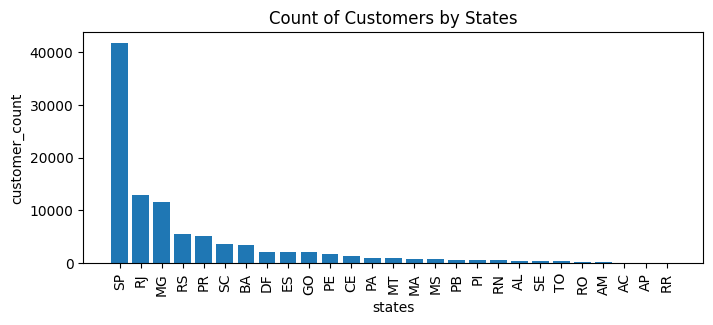

In [7]:
query = """ SELECT customer_state ,COUNT(customer_id)
FROM customers GROUP BY customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018

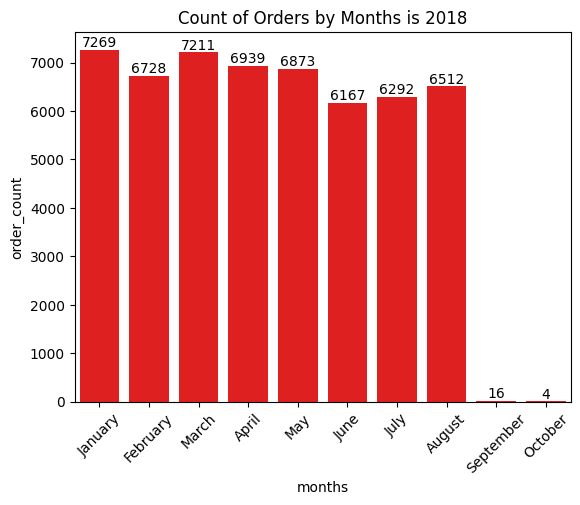

In [9]:
query = """ SELECT MONTHNAME(order_purchase_timestamp) months, COUNT(order_id) order_count
FROM orders WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city

In [10]:
query = """WITH count_per_order as 
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY average_orders DESC
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category

In [11]:
query = """SELECT UPPER(products.product_category) category, 
ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) sales_percentage
FROM products JOIN order_items 
ON products.product_id = order_items.product_id
JOIN payments 
ON payments.order_id = order_items.order_id
GROUP BY category ORDER BY sales_percentage DESC"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased

In [16]:
cur = db.cursor()
query = """SELECT products.product_category, 
COUNT(order_items.product_id),
ROUND(AVG(order_items.price),2)
FROM products JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation is", a[0][-1])

The correlation is -0.10631514167157567


# Calculate the total revenue generated by each seller, and rank them by revenue

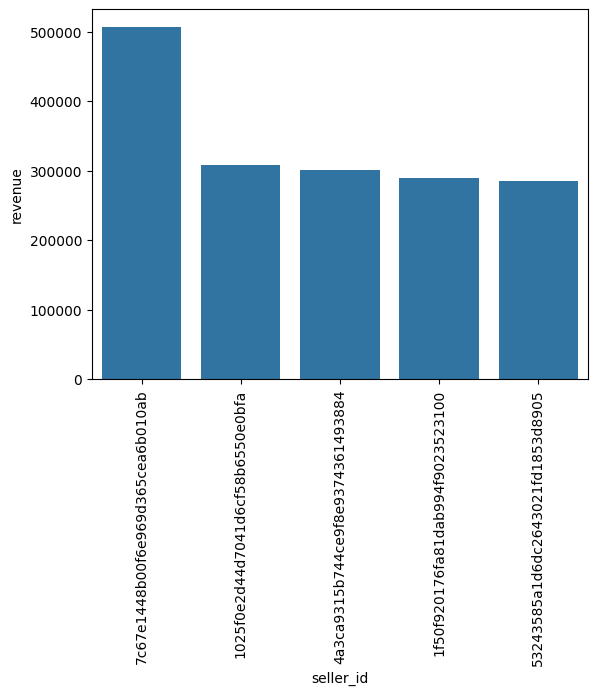

In [12]:
query = """ SELECT *, DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn FROM
(SELECT order_items.seller_id, SUM(payments.payment_value)
revenue FROM order_items JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) AS a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [13]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM
(SELECT orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value AS payment
FROM payments JOIN orders
ON payments.order_id = orders.order_id) AS a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year

In [18]:
query = """SELECT years, months , payment, SUM(payment)
OVER(ORDER BY years, months) cumulative_sales FROM 
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months order by years, months) AS a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales

In [19]:
query = """WITH a AS(SELECT YEAR(orders.order_purchase_timestamp) AS years,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years ORDER BY years)

SELECT years, ((payment - LAG(payment, 1) OVER(ORDER BY years))/
LAG(payment, 1) OVER(ORDER BY years)) * 100 FROM a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

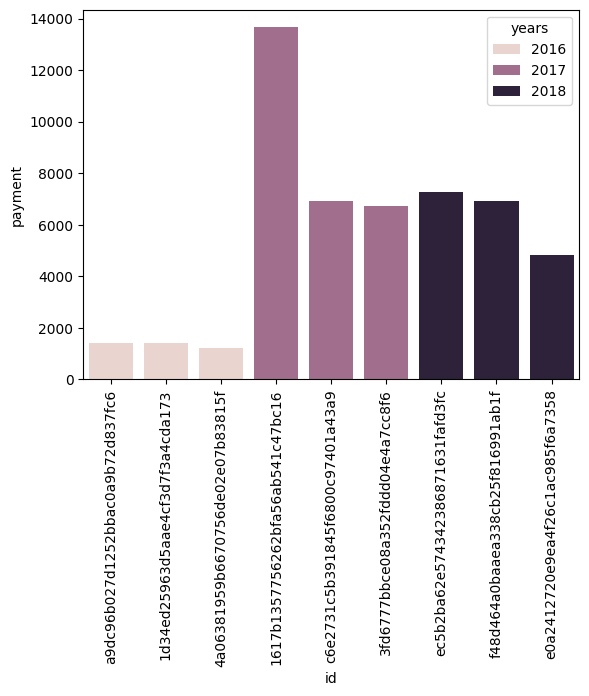

In [20]:
query = """SELECT years, customer_id, payment, d_rank
FROM
(SELECT YEAR(orders.order_purchase_timestamp) years,
orders.customer_id,
SUM(payments.payment_value) payment,
DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp)
ORDER BY SUM(payments.payment_value) DESC) d_rank
FROM orders JOIN payments 
ON payments.order_id = orders.order_id
GROUP BY YEAR(orders.order_purchase_timestamp),
orders.customer_id) AS a
WHERE d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()